In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn import svm

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits

from sklearn.inspection import DecisionBoundaryDisplay


import seaborn as sns

import pandas as pd

In [2]:
## Load sample data
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
print(target_names)


['setosa' 'versicolor' 'virginica']


# Singular value decomposition

"X_temp" is a design matrix;
"U" is (n * n) unitary matrix;
"sigma" is a (n * d) rectangular diagonal matrix with non-negative real numbers on the diagonal;
"W" is the projection matrix (i.e., transformation matrix) for linear transformation;

"U" and "W" are orthogonal matrices: U.T.dot(U) = I, W.T.dot(W) = I

SVD is written as: X_temp = U@(sigma)@(W.T)

Check these posts:

1)https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
2)https://www.samlau.me/test-textbook/ch/19/pca_svd.html#principal-component-analysis

In [3]:
svd = np.linalg.svd

X_temp = np.array([
    [1, 0, 5, 5],
    [0, 4, 10, 6],
    [0, 0, 2, 3]
])

U, s, WT = svd(X_temp,  full_matrices=False)

## Check SVD
print("Reconstruction of X_temp:")
print(U @ np.diag(s) @WT)

Reconstruction of X_temp:
[[ 1.00000000e+00  8.04911693e-16  5.00000000e+00  5.00000000e+00]
 [ 4.75314232e-16  4.00000000e+00  1.00000000e+01  6.00000000e+00]
 [ 8.88178420e-16 -7.77156117e-16  2.00000000e+00  3.00000000e+00]]


(150, 4)
Data Covariance Matrix: 
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]
Principal Directions:
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]
Singular values:
[20.92306556 11.7091661   4.69185798  1.76273239]
Eigenvalues:
[2.93808505 0.9201649  0.14774182 0.02085386]


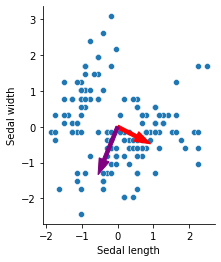

In [5]:
## Standardize the iris data
scaler = StandardScaler()

X_std = scaler.fit_transform(X)
#X_std = scaler.fit_transform(iris.data[:, :2]) # we only take the first two features of iris for this example
print(X_std.shape)

## Verify the covariance matrix C is symmetric
C = (X_std.T @ X_std)/(X_std.shape[0] - 1)
print("Data Covariance Matrix: ")
print(C)

## Hence, perform singular value decomposition of X_std

## Compute the SVD of X_std
U, s, WT = svd(X_std,  full_matrices=False)
print("Principal Directions:")
print(WT)

print("Singular values:")
print(s)

print("Eigenvalues:")
eigen_val = np.power(s, 2)/(X_std.shape[0]-1) ## with (n-1) degree of freedom
print(eigen_val)

## PCA results
#0 eigenvector's eigenvalue: 2.9380850501999953
#1 eigenvector's eigenvalue: 0.9201649041624888

## Plot the principal directions (i.e.,eigenvectors)
sns.scatterplot(x=X_std[:,0], y=X_std[:,1])
sns.despine()
plt.arrow(0, 0, WT[0, 0], WT[0, 1], width=0.1, color='red')
plt.arrow(0, 0, WT[1, 0], WT[1, 1], width=0.1, color='purple')
plt.xlabel("Sedal length")
plt.ylabel("Sedal width")
plt.gca().set_aspect(1)



In [6]:
print("Check orthogonality of WT:")
print(WT.T @ WT)

print("Check the eigenvectors' L2 norm:")
for i in range(WT.shape[0]):
    print(np.linalg.norm(WT[:,0]))
    
print("Compute eigenvalues:")
for i in range(WT.shape[0]):
    lamda = WT[:,i].T @ C @ WT[:,i]
    print(i, "eigenvector's eigenvalue:", lamda, "/loading:", np.sqrt(eigen_val))


##0 eigenvector's eigenvalue: 2.9380850501999953
##1 eigenvector's eigenvalue: 0.9201649041624888

Check orthogonality of WT:
[[ 1.00000000e+00  2.35922393e-16 -4.16333634e-16 -2.49800181e-16]
 [ 2.35922393e-16  1.00000000e+00  4.85722573e-16 -1.38777878e-17]
 [-4.16333634e-16  4.85722573e-16  1.00000000e+00 -4.44089210e-16]
 [-2.49800181e-16 -1.38777878e-17 -4.44089210e-16  1.00000000e+00]]
Check the eigenvectors' L2 norm:
1.0
1.0
1.0
1.0
Compute eigenvalues:
0 eigenvector's eigenvalue: 2.6070384562204456 /loading: [1.71408432 0.95925226 0.38437198 0.14440866]
1 eigenvector's eigenvalue: 0.8979738471733224 /loading: [1.71408432 0.95925226 0.38437198 0.14440866]
2 eigenvector's eigenvalue: 0.3025666501261013 /loading: [1.71408432 0.95925226 0.38437198 0.14440866]
3 eigenvector's eigenvalue: 0.21926668406402336 /loading: [1.71408432 0.95925226 0.38437198 0.14440866]


In practice, we use a simpler method to compute the reduced dimension 𝐗 which arises from the following equivalence:
X = U @ sigma @ W.T -->
X @ W = U @ sigma @ W.T @ W --> (W.T @ W = I)
X @ W = U @ sigma

We can compute "U @ sigma" and then remove columns until we achieve our desired dimensionality.
We call the columns of "U @ sigma" the principal components of 𝐗.

In [7]:
## Compute the principal components
pcs = U @ np.diag(s)
print("Shape of Principal components of data:",pcs.shape)

Shape of Principal components of data: (150, 4)


In [8]:
## Keep the first "k" principal components
k = 1
print("Shape of first k pc:",pcs[:, 0:k].shape)

Shape of first k pc: (150, 1)


         pc_1      pc_2  label
0   -2.264703  0.480027      0
1   -2.080961 -0.674134      0
2   -2.364229 -0.341908      0
3   -2.299384 -0.597395      0
4   -2.389842  0.646835      0
..        ...       ...    ...
145  1.870503  0.386966      2
146  1.564580 -0.896687      2
147  1.521170  0.269069      2
148  1.372788  1.011254      2
149  0.960656 -0.024332      2

[150 rows x 3 columns]


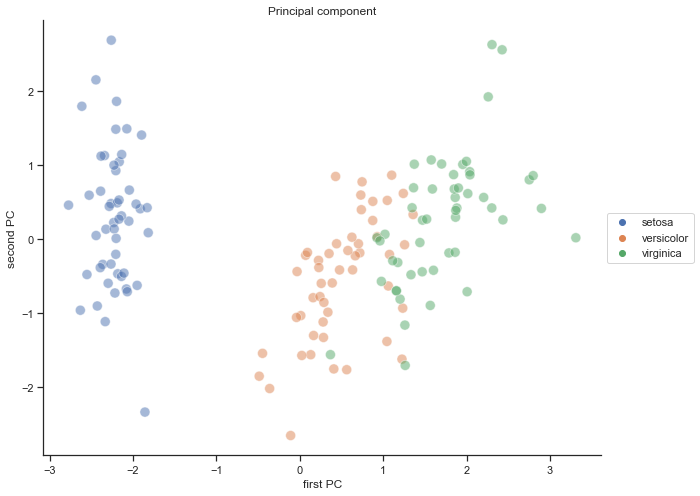

In [9]:
## Plot the first 2 principal components using SVD, and compare the result with sklearn PCA 
pcs_df = pd.DataFrame({"pc_1": pcs[:,0],
                       "pc_2": -pcs[:,1], ## flip the vertical axis
                       "label": y
})

print(pcs_df)

def plot_2d(X_fitted, show_loading=False):
    """Plot PCA results"""
    plt.figure(figsize =(10, 8))

    X_fitted['class_label'] = X_fitted['label'].map({0: "setosa", 1: "versicolor", 2:"virginica"})

    hue_order = ["setosa", "versicolor", "virginica"]
    
    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=X_fitted, 
                    x="pc_1", 
                    y="pc_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 100,
                    alpha = 0.5)
    sns.despine()
    
    ## Show loadings on the principle components
    if show_loading == True:
        pc_colors = ["black", "red"]
        for i, (singular_val, comp, var, pc_color) in enumerate(zip(pca["pca"].singular_values_, pca["pca"].components_, pca["pca"].explained_variance_, pc_colors)):
            print(i, "eigenvector's eigenvalue:", var)
            print(i, "singular value", singular_val)
            comp = comp * np.sqrt(var)  # scale component by its variance explanation power (i.e., Loading)
            plt.plot(
                [0, comp[0]],
                [0, comp[1]],
                label=f"Component {i}",
                linewidth=5,
                color=pc_color,
            )
        
    
    plt.title("Principal component")
    plt.xlabel("first PC")
    plt.ylabel("second PC")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_2d(pcs_df)
    


# PCA

         pc_1      pc_2  label
0   -2.264703  0.480027      0
1   -2.080961 -0.674134      0
2   -2.364229 -0.341908      0
3   -2.299384 -0.597395      0
4   -2.389842  0.646835      0
..        ...       ...    ...
145  1.870503  0.386966      2
146  1.564580 -0.896687      2
147  1.521170  0.269069      2
148  1.372788  1.011254      2
149  0.960656 -0.024332      2

[150 rows x 3 columns]
0 eigenvector's eigenvalue: 2.938085050199996
0 singular value 20.923065561236466
1 eigenvector's eigenvalue: 0.9201649041624882
1 singular value 11.709166098412421


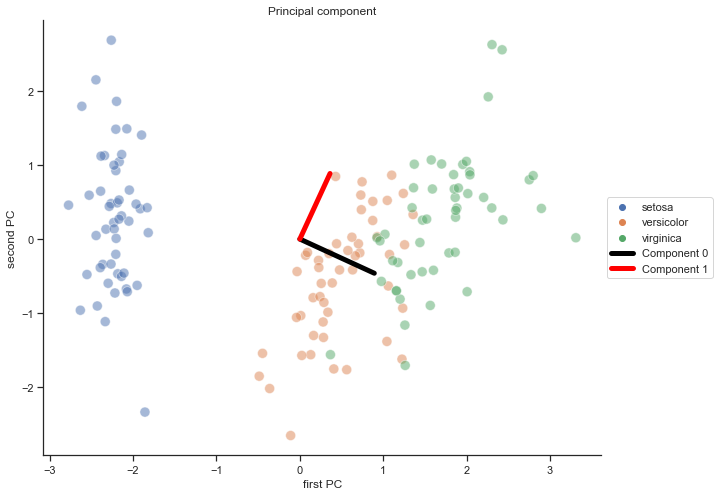

explained variance ratio (first two components): [0.72962445 0.22850762]


([<matplotlib.axis.XTick at 0x7fef1bc25fd0>,
 [Text(0, 0, ''), Text(0, 0, '')])

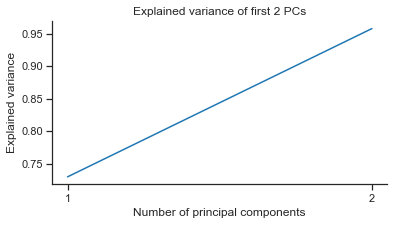

In [10]:
## Reduce to 2 dimensional
n_comp = 2

pca = make_pipeline(StandardScaler(), PCA(n_components=n_comp, random_state = 1))

## Get access to a step in Pipeline
pca["pca"]

X_fit = pca.fit_transform(X)

X_fit_df = pd.DataFrame({"pc_1": X_fit[:,0], "pc_2": X_fit[:,1], "label": y})

print(X_fit_df)


## Plot 2D dataset with principal components   
plot_2d(X_fit_df, show_loading=True)


## Percentage of variance explained for each components
explained_variances = pca["pca"].explained_variance_ratio_
print(
    "explained variance ratio (first two components): %s"
    % str(explained_variances)
)

## Plot cumulative explained variance by first 'n' principle components
explained_variances_cum = np.cumsum(pca["pca"].explained_variance_ratio_)
pc_df = pd.DataFrame(data = {'n_comp':list(range(1, n_comp+1)), 
                             'exp_var': explained_variances,
                             'exp_var_cum': explained_variances_cum})


plt.figure(figsize =(6, 3))
sns.lineplot(data=pc_df, x="n_comp", y="exp_var_cum")
sns.despine()
plt.title("Explained variance of first %s PCs" % str(n_comp))
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.xticks(np.arange(1, n_comp+1, step=1))

# Plot decision boundary from SVM

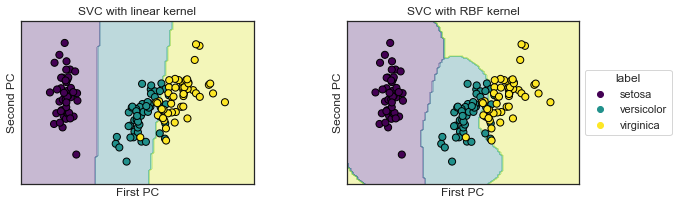

In [11]:
C = 1.0  # SVM regularization parameter

svm_models = (
    svm.SVC(kernel="linear", C=C),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
)

## Fit SVM on data after PCA
svm_models = (clf.fit(X_fit, y) for clf in svm_models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "SVC with RBF kernel",
)

# Set-up 2x2 grid for decision boundary plots
fig, sub = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_fit[:, 0], X_fit[:, 1]

for clf, title, ax in zip(svm_models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_fit,
        response_method="predict",
        cmap='viridis',
        alpha=0.3,
        ax=ax,
        xlabel="First PC",
        ylabel="Second PC",
    )
    plot = ax.scatter(X0, X1, c=y, cmap='viridis', s=50, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    #plt.legend(*plot.legend_elements(), loc='center left', title="label", bbox_to_anchor=(1, 0.5))
    plt.legend(handles=plot.legend_elements()[0],  title="label",
               loc='center left',  bbox_to_anchor=(1, 0.5), labels = ["setosa", "versicolor", "virginica"])

plt.show()


# t-SNE

In [12]:
## Load MNIST data
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
digit_label = digits.target

In [13]:
## Initialize tSNE object
perplexity = 50
tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300, random_state = 1)
tsne_results = tsne.fit_transform(data)

tsne_df = pd.DataFrame({"feature_1":tsne_results[:,0], "feature_2":tsne_results[:,1], "class_label":digit_label})


/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/chenxiliao/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.001s...
[t-SNE] Computed neighbors for 1797 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 13.138928
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.252579
[t-SNE] KL divergence after 300 iterations: 0.851951


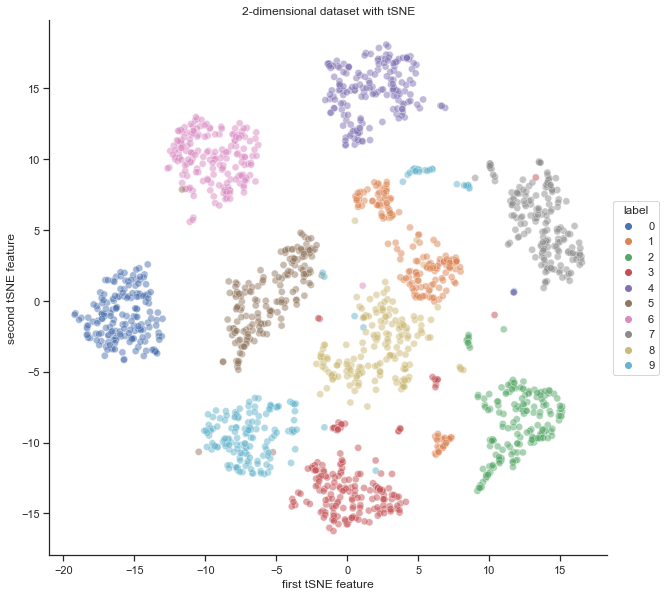

In [14]:
def plot_tSNE(X_fitted):
    """Plot tSNE results"""
    
    hue_order = list(range(10))
    
    plt.figure(figsize =(10, 10))
    
    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=X_fitted, 
                    x="feature_1", 
                    y="feature_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 50,
                    alpha = 0.5)
    sns.despine()
    
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with tSNE",
        xlabel="first tSNE feature",
        ylabel="second tSNE feature",
    )
    
    plt.legend(loc='center left', title="label", bbox_to_anchor=(1, 0.5))
    plt.show()
     
plot_tSNE(tsne_df)